In [ ]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import datetime, os
import random
from torch.nn.functional import normalize
random.seed(10)

In [ ]:
!pip install wfdb

In [ ]:
import wfdb

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#Descargar el dataset
wfdb.dl_database("mitdb","/content/gdrive/MyDrive/CNN_DATA/Dataset")

In [ ]:
#data = wfdb.rdrecord(record_name=f"/content/gdrive/MyDrive/CNN_DATA/Dataset/100")
#Genero una lista de los elementos del dataset
records= wfdb.get_record_list("mitdb")
for record in records:
 if record == '102' or record == '104' or record == '107' or record ==  '217': #omitiendo las señales con marcapasos
  records.remove(record)
#La visualizo
print(records)
print(len(records))

['100', '101', '103', '105', '106', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']
44


['+', 'N'] [28  1]


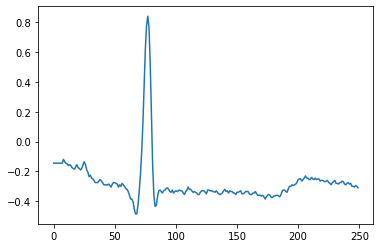

In [ ]:
#Visualizamos una muestra de los datos:
  #obtenemos una grabacion de la muestra 0 a 250 (aproximadamente un qrs)
recordsig = wfdb.rdrecord("/content/gdrive/MyDrive/CNN_DATA/Dataset/100", sampto=250, channels=[0])
recordann = wfdb.rdann("/content/gdrive/MyDrive/CNN_DATA/Dataset/100","atr", sampto=250,return_label_elements=['symbol', 'label_store'])

  #convertimos a matriz numpy
muestra_1 = recordsig.p_signal
simbolo=recordann.symbol
etiqueta=recordann.label_store #trabajaremos con este


  #Podemos visualizar la muestra en matriz:
print(simbolo, etiqueta)


  #Podemos visualizar la muestra graficamente con matplot
%matplotlib inline 
plt.plot(muestra_1)
#plt.savefig('fig1.png')#con este comando podemos guardar esa imagen

Hay que recordar lo que physionet declara que significan los simbolos de sus anotaciones:

1 = 'N' = Normal beat

Otros = Arritmia

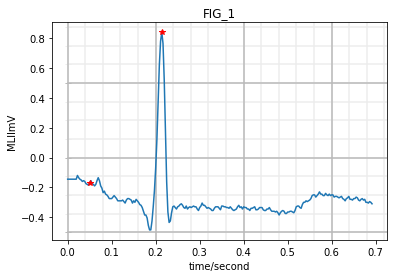

In [ ]:
#Incluso podemos generar una imagen en la cual visualizar la etiqueta en el complejo dado:
wfdb.plot_wfdb(recordsig,recordann, time_units='seconds',title='FIG_1',ecg_grids='all')

In [ ]:
#ahora voy a sacar un vector correspondiente a 1 complejo pqrst
#un loop que itere los elementos y obtenda un vector cada 250 muestras y los almacene en una matriz
cont=0
#hacemos listas vacias para almacenar nuestros datos
muestras_lista=[]
etiquetas_lista=[]

for record in records:
  for i in range(0, 171000*2, 750):#con una muestra cada 750 datos para tener aprox 10k datos
   recordsig=wfdb.rdrecord(f"/content/gdrive/MyDrive/CNN_DATA/Dataset/{record}",sampfrom=i, sampto=i+750, channels=[0])
   recordann=wfdb.rdann(f"/content/gdrive/MyDrive/CNN_DATA/Dataset/{record}","atr",sampfrom=i, sampto=i+750, return_label_elements=['label_store'])

   etiquetas_lista.append(recordann.label_store) #trabajaremos con los numeros de las etiquetas y no con su caracter asociado
  
   muestras_lista.append(recordsig.p_signal)#Estas de momento las dejaremos como numpy arrays
   muestras_lista[cont]=muestras_lista[cont].squeeze()#Eliminamos la dimension vacia extra que nos dan
   #print(muestras_lista[i].shape)

   cont=cont+1 #para saber cuantas muestras se han generado
   print(cont)

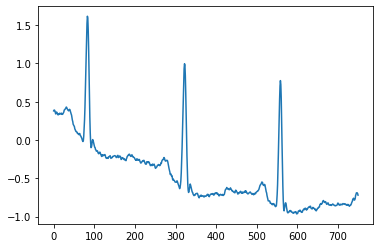

In [ ]:
plt.plot(muestras_lista[20000]) #Mostrando una de las imagenes

In [ ]:
def NormalizeData(data): #funcion para normalizar
    #return (data - np.min(data)) / (np.max(data) - np.min(data))
    result = (data - np.min(data))/np.ptp(data)
    return result

<class 'torch.Tensor'>
<class 'torch.Tensor'>


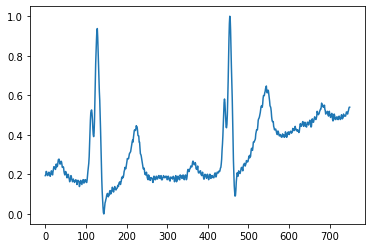

In [ ]:
#Normalizamos los datos:
for i in range(len(muestras_lista)):
  muestras_lista[i]=NormalizeData(muestras_lista[i])


#Necesitaremos que sean tensores float
muestras_lista = [torch.from_numpy(item).float() for item in muestras_lista]
etiquetas_lista = [torch.from_numpy(item).float() for item in etiquetas_lista]
plt.plot(muestras_lista[3343].numpy()) #podemos ver los datos ya normalizados

#Confirmamos que el datatype sea tensor:
print(type(etiquetas_lista[0]))
print(type(muestras_lista[0]))


In [ ]:
print(etiquetas_lista[:5]) #podemos visualizar las etiquetas que tenemos generadas
#print(muestras_lista[:1])

[tensor([28.,  1.,  1.,  1.]), tensor([1., 1.]), tensor([1., 1., 8.]), tensor([1., 1., 1.]), tensor([1., 1.])]


In [ ]:
#Ahora necesitamos aclarar bien que etiqueta debera recibir la red, en este caso particular solo queremos que nos diga si el complejo
#analizado tiene o no arritmia, por lo que a nuestra lista que almacena la etiqueta la pondremos a 1 si para indicar que si hay arrtimia
#y a 0 para indicar que no
for i in range(10032*2):
  if 1 in etiquetas_lista[i]: #recordemos que 28 es el indicador de un ritmo desincronizado
    etiquetas_lista[i]=0
  else:
    etiquetas_lista[i]=1


In [ ]:
#Vamos a ver que proporcion tenemos en los datos
dict(zip(etiquetas_lista,map(lambda x: etiquetas_lista.count(x),etiquetas_lista)))
#Esto nos mostrara un diccionario donde nos dira en cuantos datos hay arritmia y en cuantos  no (recordando que 1 es para arritmia y 0 para no arritmia)

{0: 16093, 1: 3971}

In [ ]:
#Metemos los datos a un dataframe, para que sea mas entendible, haremos 2 dataframes, uno para los 
#Datos de entrenamiento y otro para los datos de testing
DATAF_Test= pd.DataFrame(columns=['señal','etiqueta'])
for i in range(2000*2): # 20% del total
  DATAF_Test=DATAF_Test.append({'señal': muestras_lista[i], 'etiqueta':etiquetas_lista[i]}, ignore_index=True)
  #print(DATAF_Test)   #Con esto visualizariamos la creacion del dataframe

DATAF_Train= pd.DataFrame(columns=['señal','etiqueta'])
for i in range(2000*2, 10000*2): #80% del total
  DATAF_Train=DATAF_Train.append({'señal': muestras_lista[i], 'etiqueta':etiquetas_lista[i]}, ignore_index=True)
  #print(DATAF_Train)  #Con esto visualizariamos la creacion del dataframe

In [ ]:
#Lo podemos exportar a  un CSV
DATAF_Test.to_csv('/content/gdrive/MyDrive/CNN_DATA/ARRITMIA_DATA_Test.csv', index=False)
DATAF_Train.to_csv('/content/gdrive/MyDrive/CNN_DATA/ARRITMIA_DATA_Train.csv', index=False)

In [ ]:
#Hacemos una clase que tenga metodos "len" y "getitem" los cuales son solicitados mas adelante
class ProcessDataFrame(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.x = self.dataset['señal'].values
        self.y = self.dataset['etiqueta'].values
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
#Creamos objetos para train y test de la clase para procesar

Data_Test=ProcessDataFrame(DATAF_Test)
Data_Train=ProcessDataFrame(DATAF_Train)


In [ ]:
#Usamos dataloader de torch para alistar los datos para la red
#Es aqui donde se requiere que los datos entregados sean un objeto con los atributos mencionados (len y getitem)
loaders = {
    'train' : torch.utils.data.DataLoader(Data_Train, 
                                          batch_size=16, 
                                          shuffle=True, 
                                          num_workers=1), 
    'test'  : torch.utils.data.DataLoader(Data_Test, 
                                          batch_size=16, 
                                          shuffle=True, 
                                          num_workers=1)}
loaders

In [ ]:
#Checamos el tamaño de cada loader, es importante que sea divisible entre 5, el batchsize que usamos
print(len(loaders['test']))
print(len(loaders['train']))

250
1000


In [ ]:
from torch.nn.modules.activation import ReLU

class CNN(torch.nn.Module):
	def __init__(self):
		super().__init__()
		self.model = torch.nn.Sequential(
			torch.nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 1, padding = 1),
			torch.nn.ReLU(),
			torch.nn.Conv1d(in_channels = 32, out_channels = 1, kernel_size = 1, padding = 1),
			torch.nn.ReLU(),

			torch.nn.Flatten(),
			torch.nn.Linear(754, 512),
			torch.nn.ReLU(),
			torch.nn.Linear(512, 1),
      torch.nn.Sigmoid(),
      torch.nn.Linear(1, 1),
      torch.nn.Dropout()
		)

	def forward(self, x):
		return self.model(x).view(16)

In [ ]:
cnn = CNN() #"materializamos" el modelo
print(cnn)

In [ ]:
# Función de costo
criterion = nn.BCELoss()
# Función de optimización
optimizer = optim.Adam(cnn.parameters(), lr = 0.5)

In [ ]:
num_epochs = 10
train_loss_list = []
for epoch in range(num_epochs):
 print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
 train_loss = 0
 #Iterating over the training dataset in batches
 cnn.train(True)
 for i, (señal, etiqueta) in enumerate(loaders['train']):
  #Calculating the model output and the cross entropy loss
  señal=señal.view(16,1,750) #acomodamos los datos de muestra para que sean congruentes a batch, 1 channel y 750 longitud de señal
  outputs = cnn(señal)
  señal=señal.view(16,750)
  plt.plot(señal)
  for i in range(16): #Definiendo el rango, resultado negativo sera 0 y positivo sera 1
    if outputs[i] < 0:
      outputs[i]=0
    else:
      outputs[i]=1
  #print(outputs)
  #señal= Variable(señal)
  #etiqueta= Variable(etiqueta)
  loss = criterion(outputs, etiqueta.float())
  #Updating weights according to calculated loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  train_loss += loss.item()	
 #Printing loss for each epoch
 train_loss_list.append(train_loss/len(loaders['train']))
 print(f"Training loss = {train_loss_list[-1]}")
	
#Plotting loss for all epochs
plt.plot(range(1,num_epochs+1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")


In [ ]:
# Visualización de resultados
writer = SummaryWriter()

for n_iter in range(25):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [ ]:
# Evaluación

def test():
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        for señal, etiqueta in loaders['test']:
            #print(señal.size())
            señal=señal.view(16,1,750)
            test_output = cnn(señal)
            #print(señal)
            for i in range(16): #Definiendo el rango, resultado negativo sera 0 y positivo sera 1
             if test_output[i] < 0:
                test_output[i]=0
             else:
              test_output[i]=1
            pred_y = test_output
            #print(pred_y)
            accuracy = (pred_y == etiqueta).sum().item() / float(etiqueta.size(0))
            pass

    print('Test Accuracy of the model on the 2000 samples: %.4f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 2000 samples: 0.8125
